In [2]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval

import networkx as nx


In [3]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]

color_4st=['green','red','blue','black']

In [4]:
def matrixplot(data,title):
	plt.figure()
	plt.imshow(data,vmin =-0.3,vmax = 0.3, cmap = 'jet')
	plt.colorbar()
	plt.title(title)
	plt.xticks(range(32),labels = labels,rotation = 'vertical')
	plt.yticks(range(32),labels = labels,rotation = 'horizontal')

In [5]:
# load chan locs for topoplots
dict_loc=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Archived/Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [6]:
# variable names for plotting
states4names=['Independent','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [7]:
indices=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [8]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']                         

In [9]:
np.shape(indices['R_lead_synco_ind'])

(18,)

In [10]:
np.shape(eeg_empirical_correlation144x2)

(144, 2, 7, 32, 32)

In [11]:
#organize the correlation matrices
R_follow_synco = np.zeros((36,7,32,32)) # "R" stands for "Correlation Matrices" here
R_lead_synco = np.zeros((36,7,32,32))
R_ind_synco = np.zeros((36,7,32,32))
R_mutual_synco = np.zeros((36,7,32,32))
R_follow_synch = np.zeros((36,7,32,32))
R_lead_synch = np.zeros((36,7,32,32))
R_ind_synch = np.zeros((36,7,32,32))
R_mutual_synch = np.zeros((36,7,32,32))

R_follow_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:] # L-following in R_Lead condition
R_follow_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:] # R-following in L_Lead condition
R_lead_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:] # L_leading in L_Lead condition
R_lead_synco[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:] # R_leading in R_Lead condition
R_mutual_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] # 
R_mutual_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
R_ind_synco[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
R_ind_synco[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

R_follow_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
R_follow_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
R_lead_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
R_lead_synch[18:36,:,:,:] =eeg_empirical_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
R_mutual_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
R_mutual_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
R_ind_synch[0:18,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
R_ind_synch[18:36,:,:,:] = eeg_empirical_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]


In [12]:
np.shape(R_mutual_synco)

(36, 7, 32, 32)

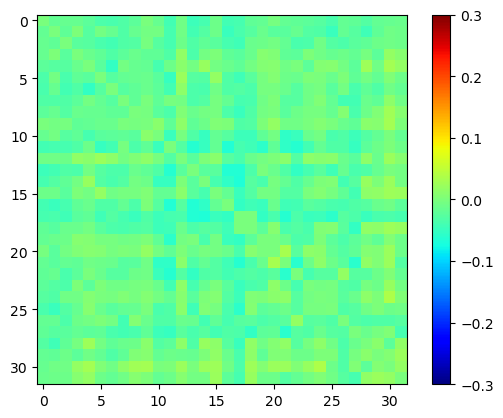

In [13]:
x = np.mean(R_follow_synco- R_lead_synco,axis = 0)
plt.imshow(x[5,:,:],cmap = 'jet',vmin = -0.3, vmax = 0.3)
plt.colorbar()


In [14]:
#organize the adjacency matrices from partial correlation
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)
A_follow_synco = np.zeros((36,7,32,32))
A_lead_synco = np.zeros((36,7,32,32))
A_ind_synco = np.zeros((36,7,32,32))
A_mutual_synco = np.zeros((36,7,32,32))
A_follow_synch = np.zeros((36,7,32,32))
A_lead_synch = np.zeros((36,7,32,32))
A_ind_synch = np.zeros((36,7,32,32))
A_mutual_synch = np.zeros((36,7,32,32))

A_follow_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synco_ind'],0,:,:,:]
A_follow_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],1,:,:,:]
A_lead_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synco_ind'],0,:,:,:]
A_lead_synco[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synco_ind'],1,:,:,:]
A_mutual_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],0,:,:,:] 
A_mutual_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synco_ind'],1,:,:,:]
A_ind_synco[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],0,:,:,:]
A_ind_synco[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synco_ind'],1,:,:,:]

A_follow_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['R_lead_synch_ind'],0,:,:,:]
A_follow_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],1,:,:,:]
A_lead_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['L_lead_synch_ind'],0,:,:,:]
A_lead_synch[18:36,:,:,:] =eeg_partial_correlation144x2[indices['R_lead_synch_ind'],1,:,:,:]
A_mutual_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],0,:,:,:] 
A_mutual_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Mutual_synch_ind'],1,:,:,:]
A_ind_synch[0:18,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],0,:,:,:]
A_ind_synch[18:36,:,:,:] = eeg_partial_correlation144x2[indices['Uncoupled_synch_ind'],1,:,:,:]



In [15]:
f = 1

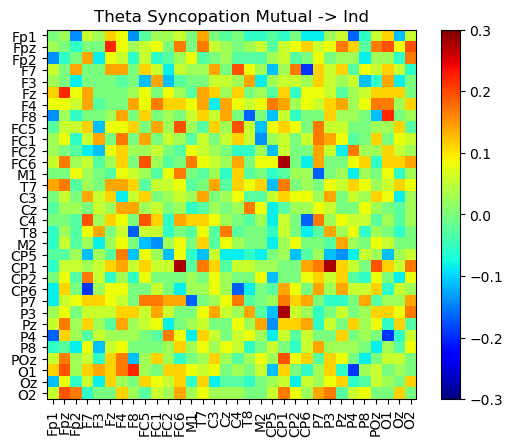

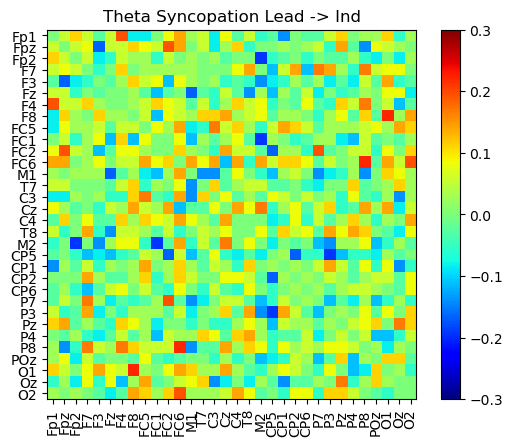

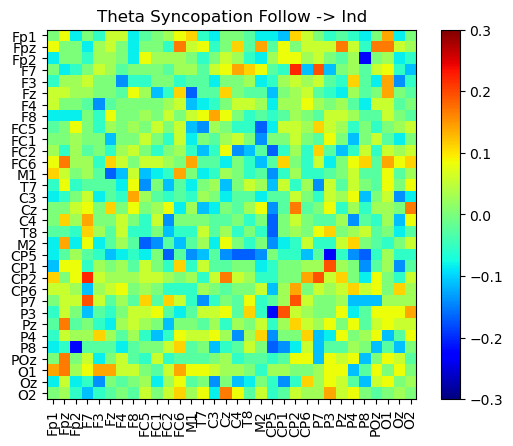

In [16]:
data = np.mean(A_mutual_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Syncopation Mutual -> Ind'
matrixplot(data,title)
data = np.mean(A_lead_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Syncopation Lead -> Ind'
matrixplot(data,title)

data = np.mean(A_follow_synco,axis = 0)[f,:,:]-np.mean(A_ind_synco,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Syncopation Follow -> Ind'
matrixplot(data,title)

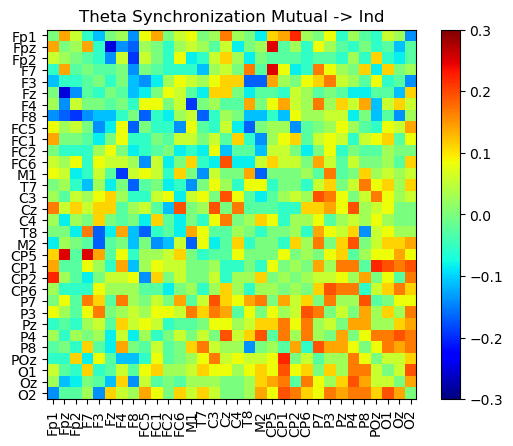

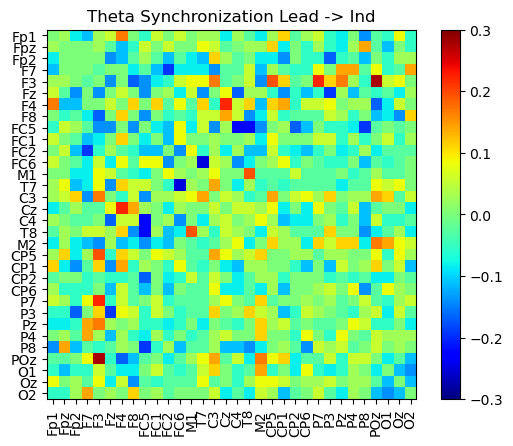

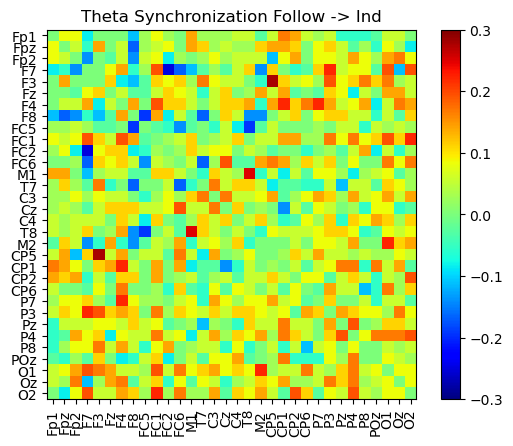

In [17]:
data = np.mean(A_mutual_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Synchronization Mutual -> Ind'
matrixplot(data,title)
data = np.mean(A_lead_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Synchronization Lead -> Ind'
matrixplot(data,title)

data = np.mean(A_follow_synch,axis = 0)[f,:,:]-np.mean(A_ind_synch,axis = 0)[f,:,:]
title = band_labels[f] + ' ' + 'Synchronization Follow -> Ind'
matrixplot(data,title)

In [18]:
np.shape(A_lead_synco[j,f,:,:])

(32, 32)

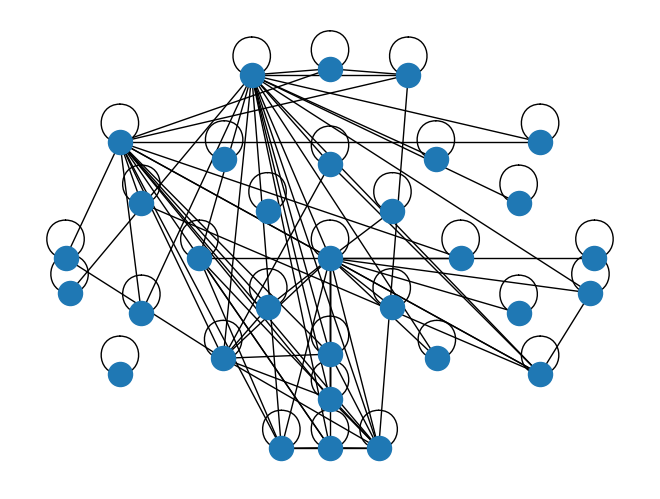

In [19]:
G=nx.from_numpy_array(A_lead_synco[j,f,:,:])
nx.draw(G,pos)

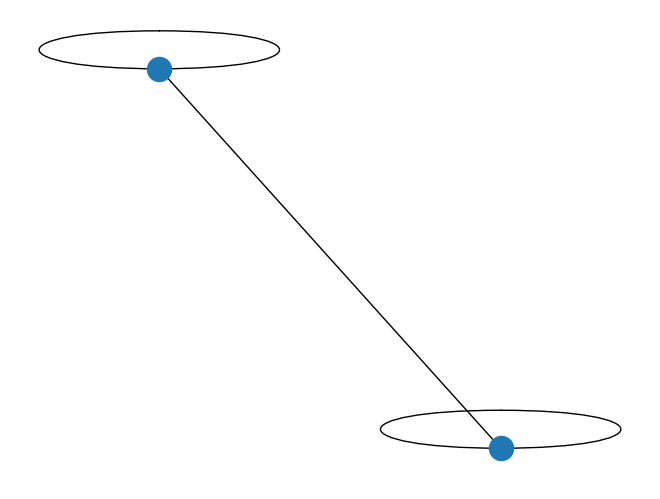

In [20]:
A = np.array([[1, 1], [2, 1]])
G = nx.from_numpy_array(A)
nx.draw(G)

In [21]:
# compute clustering coef

G_lead_synco = dict()
G_follow_synco = dict()
G_ind_synco = dict()
G_mutual_synco = dict()

c_lead_synco = np.zeros((36,32))
c_follow_synco = np.zeros((36,32))
c_ind_synco = np.zeros((36,32))
c_mutual_synco = np.zeros((36,32))

G_lead_synch = dict()
G_follow_synch = dict()
G_ind_synch = dict()
G_mutual_synch = dict()

c_lead_synch = np.zeros((36,32))
c_follow_synch = np.zeros((36,32))
c_ind_synch = np.zeros((36,32))
c_mutual_synch = np.zeros((36,32))

for j in range(36):
	G_lead_synco[j] = nx.from_numpy_array(A_lead_synco[j,f,:,:])
	x = nx.clustering(G_lead_synco[j])
	G_follow_synco[j] = nx.from_numpy_array(A_follow_synco[j,f,:,:])
	y = nx.clustering(G_follow_synco[j])
	G_ind_synco[j] = nx.from_numpy_array(A_ind_synco[j,f,:,:])
	z = nx.clustering(G_ind_synco[j])
	G_mutual_synco[j] = nx.from_numpy_array(A_mutual_synco[j,f,:,:])
	w = nx.clustering(G_mutual_synco[j])
	
	for k in range(32):
		c_lead_synco[j,k] = x[k]
		c_follow_synco[j,k] = y[k]
		c_ind_synco[j,k] = z[k]
		c_mutual_synco[j,k] = w[k]
#dc_ind = (dc_lead+dc_ind)/2


for j in range(36):
	G_lead_synch[j] = nx.from_numpy_array(A_lead_synch[j,f,:,:])
	x = nx.clustering(G_lead_synch[j])
	G_follow_synch[j] = nx.from_numpy_array(A_follow_synch[j,f,:,:])
	y = nx.clustering(G_follow_synch[j])
	G_ind_synch[j] = nx.from_numpy_array(A_ind_synch[j,f,:,:])
	z = nx.clustering(G_ind_synch[j])
	G_mutual_synch[j] = nx.from_numpy_array(A_mutual_synch[j,f,:,:])
	w = nx.clustering(G_mutual_synch[j])
	
	for k in range(32):
		c_lead_synch[j,k] = x[k]
		c_follow_synch[j,k] = y[k]
		c_ind_synch[j,k] = z[k]
		c_mutual_synch[j,k] = w[k]
#dc_ind = (dc_lead+dc_ind)/2


Text(0, 0.5, 'clustering coefficient')

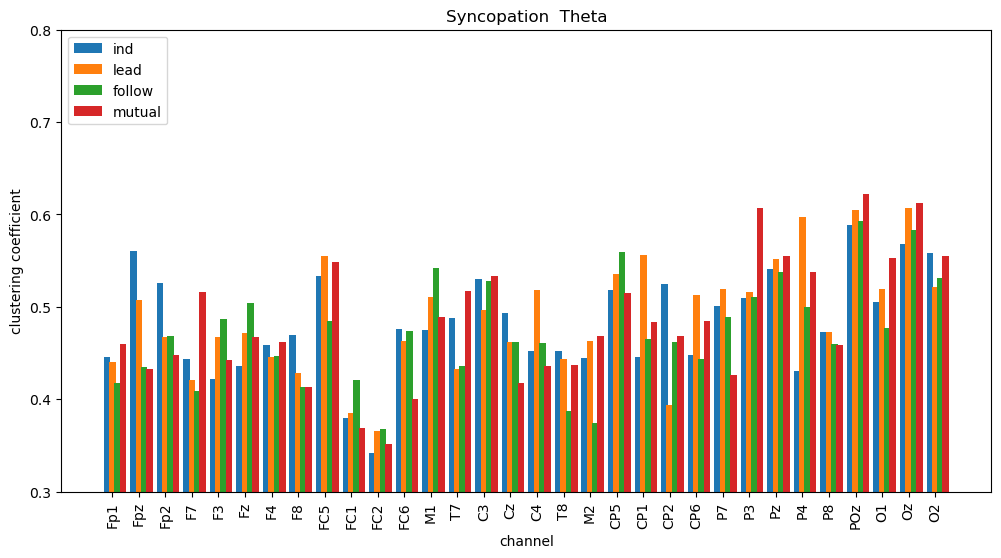

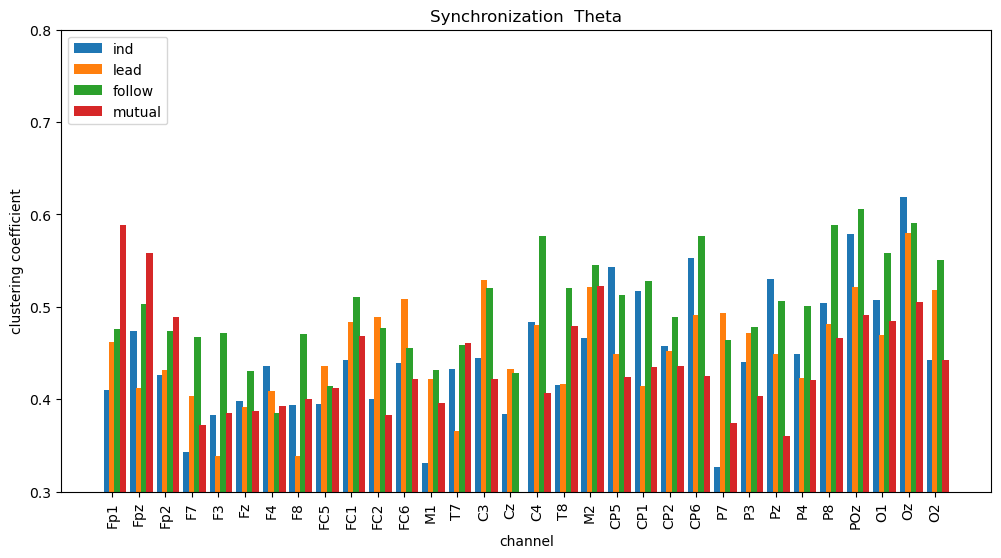

In [22]:
c_synco = [np.mean(c_ind_synco,axis = 0), np.mean(c_lead_synco,axis = 0),np.mean(c_follow_synco,axis = 0),np.mean(c_mutual_synco,axis = 0)]
c_synch = [np.mean(c_ind_synch,axis = 0), np.mean(c_lead_synch,axis = 0),np.mean(c_follow_synch,axis = 0),np.mean(c_mutual_synch,axis = 0)]
plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_synco[0],width = 0.25)
plt.bar(np.arange(32)+0.2,c_synco[1],width = 0.25)
plt.bar(np.arange(32)+0.4,c_synco[2],width = 0.25)
plt.bar(np.arange(32)+0.6,c_synco[3],width = 0.25)
plt.xticks(np.arange(32)+0.2,labels = labels,rotation = 'vertical')
plt.legend(('ind','lead','follow','mutual'), loc = 'upper left')
plt.title('Syncopation  '+band_labels[f])
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.3,0.8))

plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_synch[0],width = 0.25)
plt.bar(np.arange(32)+0.2,c_synch[1],width = 0.25)
plt.bar(np.arange(32)+0.4,c_synch[2],width = 0.25)
plt.bar(np.arange(32)+0.6,c_synch[3],width = 0.25)
plt.xticks(np.arange(32)+0.2,labels = labels,rotation = 'vertical')
plt.legend(('ind','lead','follow','mutual'),loc = 'upper left')
plt.title('Synchronization  '+band_labels[f])
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.3,0.8))
# plt.figure()
# plt.bar(range(32),c_synch)
# plt.xticks(range(32),labels = labels,rotation = 'vertical')
# plt.legend(('lead','follow','mutual','ind'))
# plt.title('Synchronization')
# plt.xlabel('channel')
plt.ylabel('clustering coefficient')

In [23]:
# load fif file
import mne
mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')

Opening raw data file ../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif...
Isotrak not found
    Range : 0 ... 2000 =      0.000 ...     1.000 secs
Ready.


C:\Users\zhouz\AppData\Local\Temp\ipykernel_27732\3113429820.py:3: RuntimeWarning: This filename (../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_object=mne.io.read_raw_fif('../Archived/Pcorr_4states_2sestype/chan_locs/TMSi32chan_loc_small.fif')


In [24]:
np.shape(c_ind_synco)

(36, 32)

(0.2, 0.7)

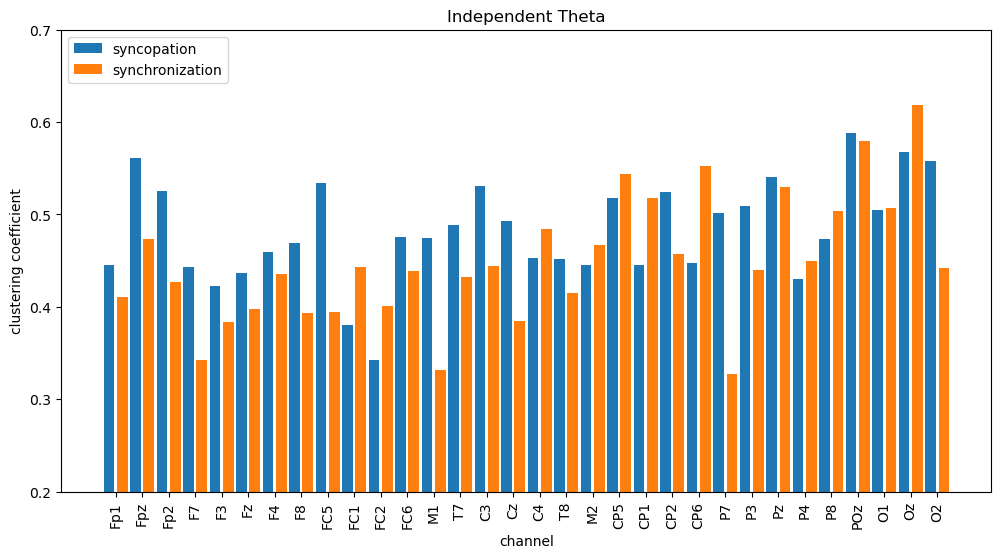

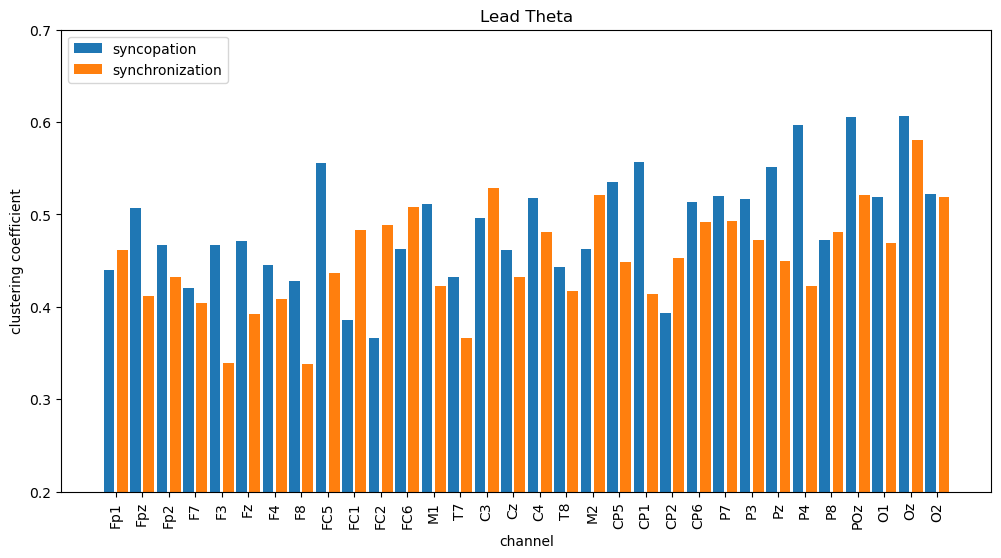

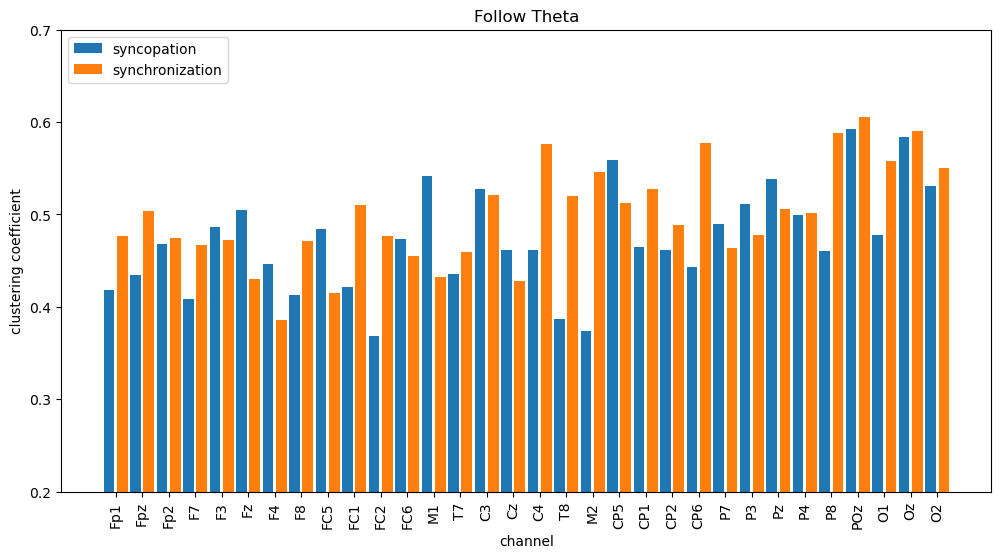

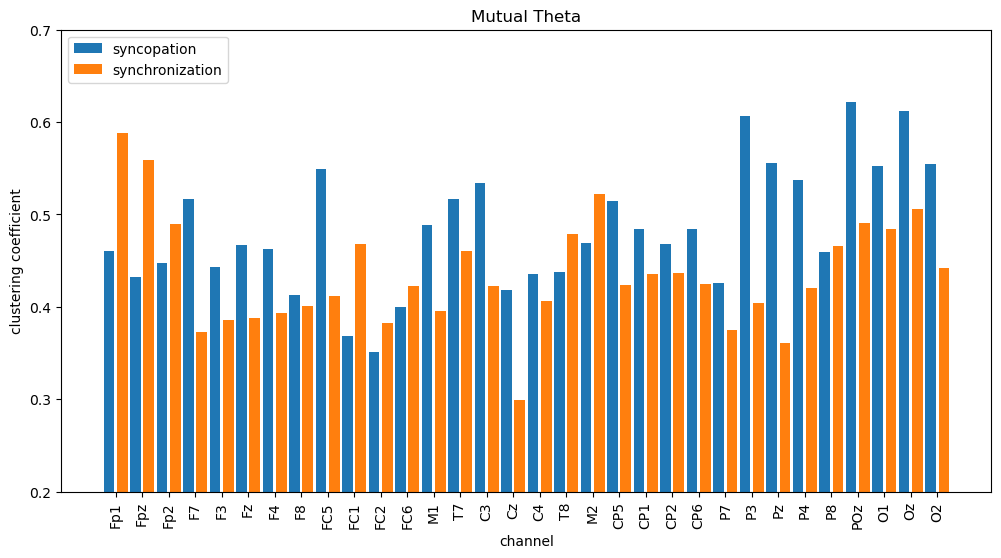

In [37]:
c_ind = [np.mean(c_ind_synco,axis = 0), np.mean(c_ind_synch,axis = 0)]
c_lead = [np.mean(c_lead_synco,axis = 0), np.mean(c_lead_synch,axis = 0)]
c_follow = [np.mean(c_follow_synco,axis = 0), np.mean(c_follow_synch,axis = 0)]
c_mutual = [np.mean(c_mutual_synco,axis = 0), np.mean(c_mutual_synch,axis = 0)]

plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_ind[0],width = 0.4)
plt.bar(np.arange(32)+0.5,c_ind[1],width = 0.4)
plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
plt.legend(('syncopation','synchronization'), loc = 'upper left')
plt.title('Independent ' + band_labels[f])
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.2,0.7))

plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_lead[0],width = 0.4)
plt.bar(np.arange(32)+0.5,c_lead[1],width = 0.4)
plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
plt.legend(('syncopation','synchronization'), loc = 'upper left')
plt.title('Lead ' + band_labels[f])
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.2,0.7))

plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_follow[0],width = 0.4)
plt.bar(np.arange(32)+0.5,c_follow[1],width = 0.4)
plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
plt.legend(('syncopation','synchronization'), loc = 'upper left')
plt.title('Follow ' + band_labels[f])
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.2,0.7))


plt.figure(figsize = (12,6))
plt.bar(np.arange(32),c_mutual[0],width = 0.4)
plt.bar(np.arange(32)+0.5,c_mutual[1],width = 0.4)
plt.xticks(np.arange(32)+0.25,labels = labels,rotation = 'vertical')
plt.legend(('syncopation','synchronization'), loc = 'upper left')
plt.title('Mutual ' + band_labels[f])
plt.xlabel('channel')
plt.ylabel('clustering coefficient')
plt.ylim((0.2,0.7))


In [ ]:
c_ind = [np.mean(c_ind_synco,axis = 0), np.mean(c_ind_synch,axis = 0)]
c_lead = [np.mean(c_lead_synco,axis = 0), np.mean(c_lead_synch,axis = 0)]
c_follow = [np.mean(c_follow_synco,axis = 0), np.mean(c_follow_synch,axis = 0)]
c_mutual = [np.mean(c_mutual_synco,axis = 0), np.mean(c_mutual_synch,axis = 0)]


In [25]:
np.shape(c_mutual_synco)

(36, 32)

In [35]:
(A_lead_synco[j,f,:,:])

array([[1., 0., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [36]:
G=nx.from_numpy_array(A_lead_synco[j,f,:,:])

In [43]:
nEdges=len(G.edges())
nEdges

173

In [31]:
tr=1
c_mutual_synco[tr,:].astype(bool)


array([ True,  True,  True,  True, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True,  True, False])

In [84]:
nEdges=200

In [86]:
c_random[:,chan]

array([0.33333333, 0.41025641, 0.3956044 , 0.41818182, 0.3956044 ,
       0.36363636, 0.47222222, 0.36263736, 0.4       , 0.36029412,
       0.4       , 0.33333333, 0.46153846, 0.375     , 0.35555556,
       0.37362637, 0.27472527, 0.46153846, 0.45454545, 0.37142857,
       0.38235294, 0.44761905, 0.46666667, 0.49090909, 0.45454545,
       0.49450549, 0.40909091, 0.36111111, 0.43956044, 0.36111111,
       0.37878788, 0.41025641, 0.37362637, 0.4       , 0.41904762,
       0.4       , 0.33333333, 0.4       , 0.38562092, 0.47222222,
       0.44871795, 0.43636364, 0.36363636, 0.3974359 , 0.46153846,
       0.24444444, 0.37142857, 0.30769231, 0.375     , 0.34558824,
       0.44871795, 0.45714286, 0.38181818, 0.47272727, 0.43939394,
       0.39285714, 0.32727273, 0.43939394, 0.33333333, 0.5       ,
       0.34558824, 0.42424242, 0.36190476, 0.41758242, 0.38181818,
       0.35164835, 0.28787879, 0.5       , 0.39393939, 0.3956044 ,
       0.53571429, 0.35555556, 0.43333333, 0.45454545, 0.45454

0.4045608230091203


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  3.,
         2.,  3.,  1.,  2.,  1.,  0., 13.,  3.,  0., 12.,  8.,  5., 12.,
        12., 33., 16., 34., 16., 35., 41., 28., 21., 57., 34., 34., 67.,
        17., 57., 33., 56., 51., 11., 48., 21., 20., 30., 21., 22., 20.,
         2., 13., 15.,  1., 13.,  3., 10.,  0.,  9.,  5.,  4.,  2.,  0.,
         3.,  0.,  0.,  5.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,
         0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  1.]),
 array([0.1       , 0.10578571, 0.11157143, 0.11735714, 0.12314286,
        0.12892857, 0.13471429, 0.1405    , 0.14628571, 0.15207143,
        0.15785714, 0.16364286, 0.16942857, 0.17521429, 0.181     ,
        0.18678571, 0.19257143, 0.19835714, 0.20414286, 0.20992857,
        0.21571429, 0.2215    , 0.22728571, 0.23307143, 0.23885714,
        0.24464286, 0.25042857, 0.25621429, 0.262     , 0.26778571,
        0.27357143, 0.2793

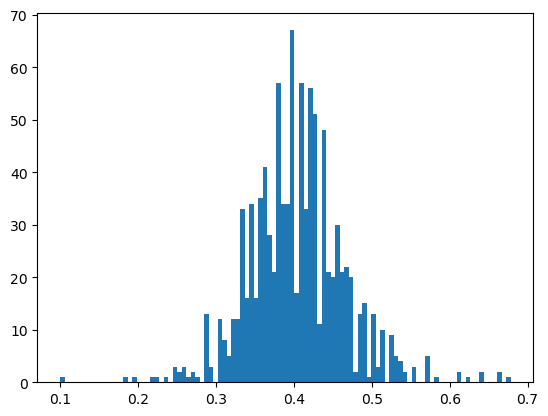

In [89]:
# nNodes=np.sum(c_mutual_synco[tr,:].astype(bool))
c_random=np.zeros((1000,32))
for sim in range(1000):
    R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
    ctr=nx.clustering(R)
    for chan in range(32):
        c_random[sim,chan]=ctr[chan]
    del(R,ctr)

chan=4
print(np.mean(c_random[:,chan],axis=0))
plt.hist(c_random[:,chan],100)


In [98]:
low_bound=np.percentile(c_random[:,chan], 5)
low_bound


0.311010101010101

In [99]:

high_bound=np.percentile(c_random[:,chan], 95)
high_bound


0.500454545454545

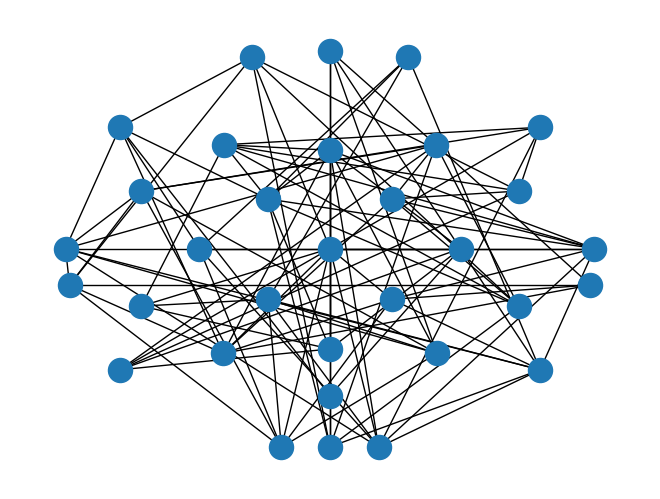

In [41]:
# networkx ggm_random_graph
# https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html
# https://tedboy.github.io/networkx/generated/networkx.generators.gnm_random_graph.html

G=nx.gnm_random_graph(32, 100, seed=None, directed=False)
nx.draw(G,pos)


